# Reading WSI Example

*Note:* This notebook assumes that `tiatoolbox` has already been installed. If it isn't, you can install it to your python environment by following guideline from https://github.com/TIA-Lab/tiatoolbox .

Welcome to tiatoolbox. This is an example to read a whole slide image (WSI) using tiatoolbox. We will load up a sample whole slide image (WSI), check out some key information, then extract some image patches from it. From this, we will examine `wsireader`, `slide_info` modules of the library.

We start by importing some related libraries.

In [1]:
from tiatoolbox.dataloader.slide_info import slide_info
from tiatoolbox.dataloader import wsireader
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300 # for high resolution figure in notebook

Then, we will load a small WSI. This WSI is provided by the user via `user_sample_wsi_path`. By default, the value is `None` and the WSI will be downloaded from the web from the provided link insted. In case of downloading from the web, the WSI will be saved under `data_dir` with the named provided in `sample_file_name`. Additionally, subsequent data generated by the notebook will also be stored under `data_dir`. Users should change the `data_dir` to the location of liking.

In [2]:
data_dir = './'
sample_file_name = 'sample_wsi_small.svs'

user_sample_wsi_path = None

if user_sample_wsi_path is None:
    sample_wsi_path = '%s/%s' % (data_dir, sample_file_name)
else:
    sample_wsi_path = user_sample_wsi_path
    sample_file_name = os.path.basename(sample_wsi_path)
if not os.path.exists(sample_wsi_path):
    r = requests.get(
        "http://openslide.cs.cmu.edu/download/openslide-testdata/Aperio/CMU-1-Small-Region.svs"
    )
    with open(sample_wsi_path, "wb") as f:
        f.write(r.content)

Now, we will create an `OpenSlideWSIReader` object to load the information from WSI. For this class, the `input_path` is the path pointing to the targeted WSI, while the `output_dir` leads to a directory for storing intermedidate outputs.

In [3]:
# create a file handler
wsi_reader = wsireader.OpenSlideWSIReader(
                input_path=sample_wsi_path, 
                output_dir='%s/output/' % data_dir)

Let's first check the basic information about this WSI such as magnification, dimension, etc.

In [4]:
wsi_info = wsi_reader.slide_info.as_dict()
# we will print out each info line by line
print(*list(wsi_info.items()), sep='\n')

('objective_power', 20.0)
('slide_dimensions', (2220, 2967))
('level_count', 1)
('level_dimensions', ((2220, 2967),))
('level_downsamples', [1.0])
('vendor', 'aperio')
('mpp', ('0.499', '0.499'))
('file_path', PosixPath('sample_wsi_small.svs'))


We can also load the thumbnail using the `slide_thumbnail` method of the object as follows,

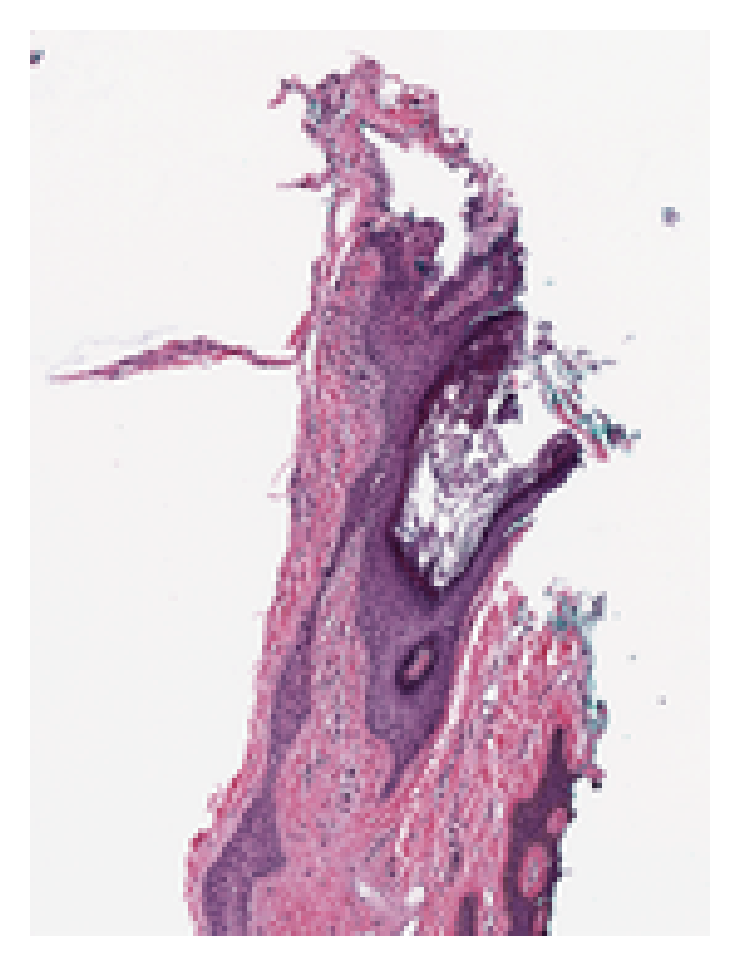

In [5]:
wsi_thumb = wsi_reader.slide_thumbnail()
plt.imshow(wsi_thumb)
plt.axis('off')
plt.show()


Now, we will see how to use the WSI object by a implementing a small task, retrieving a set of location from the WSI thumbnail we got previously then load the patches up for visualization. We prefer the patches containing only tissue. Hence, We begin with writing a `simple_get_mask` function to threshold the WSI thumbnail intensity so that the tissue is seperated out from the background. Some minor operations such as dilation are applied subsequently to prettify the output. We often call the area to highlight a specific region in the image as mask.

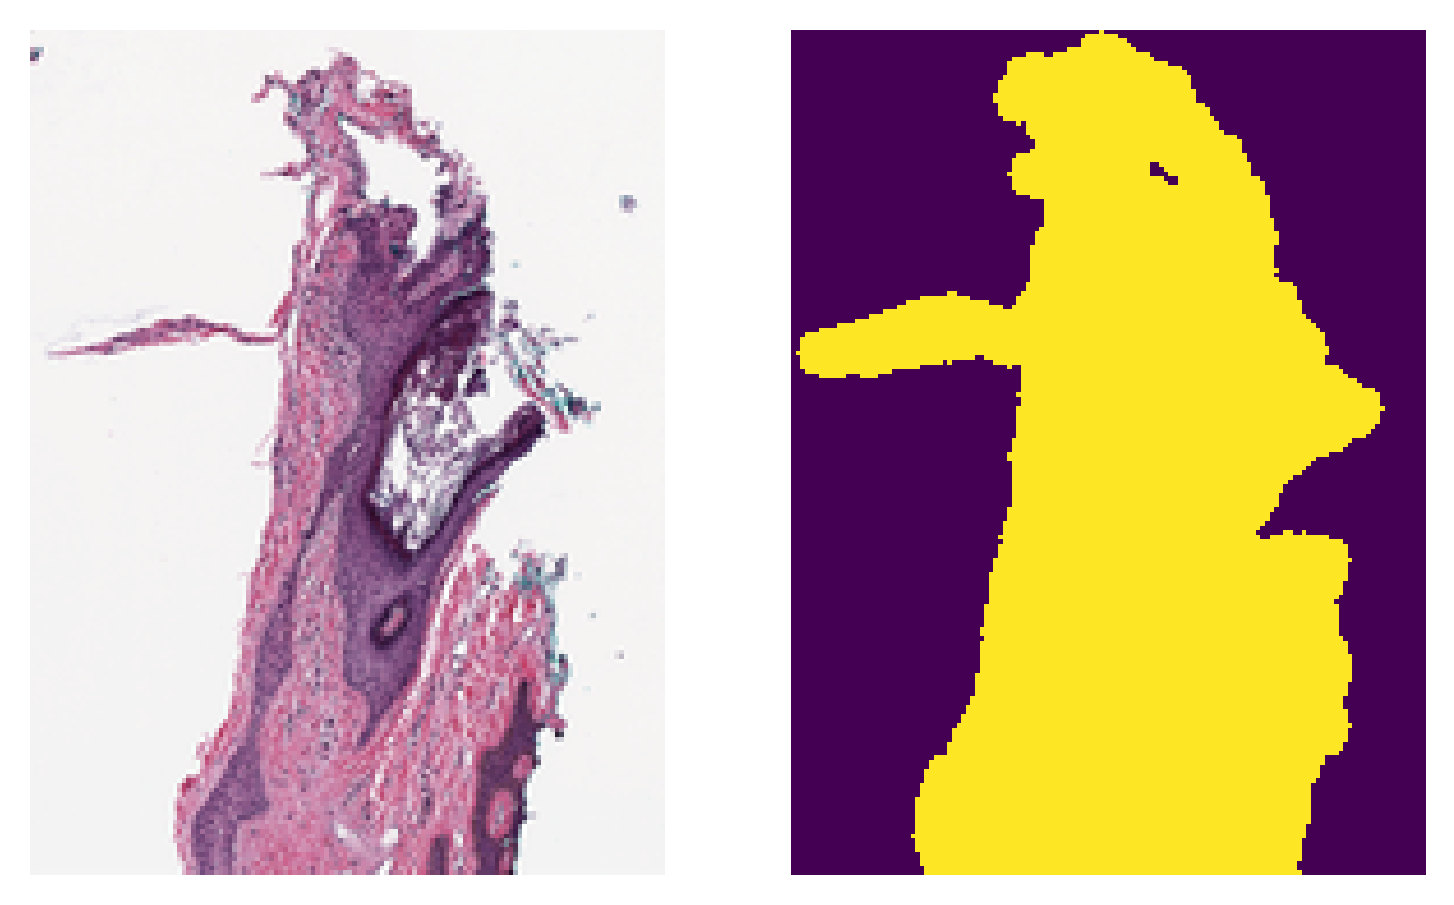

In [6]:
import cv2
import math
from skimage import morphology

# An example function using intensity thresholding and morphological operations to obtain tissue regions
def simple_get_mask(rgb):
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
    mask = morphology.remove_small_objects(mask == 0, min_size=100, connectivity=2)
    mask = morphology.remove_small_holes(mask, area_threshold=100)
    mask = morphology.binary_dilation(mask, morphology.disk(5))
    return mask

wsi_thumb_mask = simple_get_mask(wsi_thumb)
plt.subplot(1,2,1)
plt.imshow(wsi_thumb)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(wsi_thumb_mask)
plt.axis('off')
plt.show()

Now, we can write a function to find and pick up some locations to extract the patches within the tissue area. The location is defined as its top left location with repspect to the top left corner of the source image and its dimension (height and width). For computational reason, the operation is done at the thumbnail level, so we will need to map the patches location and its size back to the targeted magnification we want to extract later.

In [7]:
from scipy.ndimage.measurements import center_of_mass
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

# get the super-pixels (a.k.a rois) of the tissue area and extract 
# patches centering those super-pixel (a.k.a rois)
lores_mag = 1.25 # the magnification of the thumbnail (lores = low resolution)
hires_mag = 20 # the magnification where the patch would be extracted (hires = high resolution)
hires_patch_size = 128 # expected output patch size at higher resolution
# map the expected patch size at hires to lores
lores_patch_size = int(hires_patch_size / (hires_mag / lores_mag))


For this example, we would like to create image patches such that they can cover the entire WSI. We will use the super-pixel algorithm *SLIC* from `scikit` to do this. It will split the tissue region into regions of similar size at low resolution. Then we get the patches which center these region. We also calculate the expected number of patches that can be obtain with the given size however, note that the actual number of patches may not be the same as expected.

#Actual Patches / #Expected Patches : 200/199


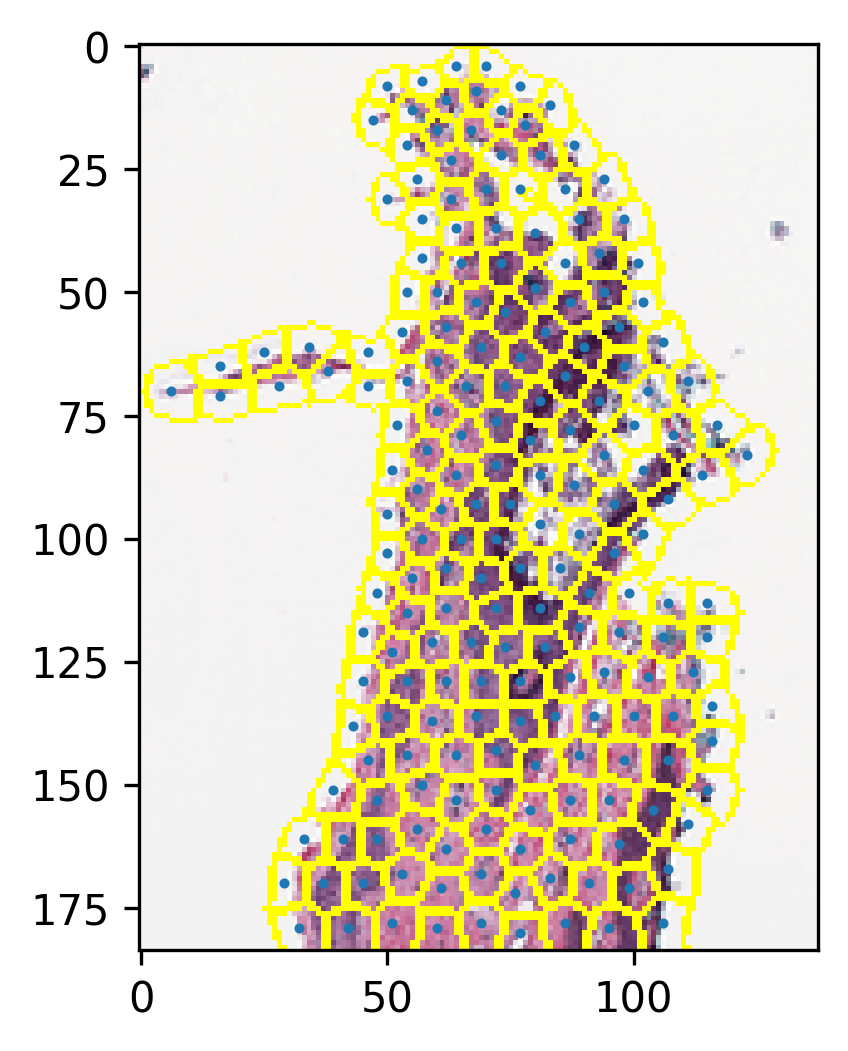

In [8]:
nr_expected_rois = math.ceil(np.sum(wsi_thumb_mask) / ((lores_patch_size ** 2)))
wsi_rois_mask = slic(wsi_thumb, 
                    mask=wsi_thumb_mask,
                    n_segments=nr_expected_rois, 
                    compactness=1000, 
                    sigma=1)
print('#Actual Patches / #Expected Patches : %d/%d' % (np.unique(wsi_rois_mask).shape[0], nr_expected_rois))

lores_rois_center = center_of_mass(wsi_rois_mask, 
                labels=wsi_rois_mask, 
                index=np.unique(wsi_rois_mask)[1:])
lores_rois_center = np.array(lores_rois_center) # coordinates is Y, X
lores_rois_center = (lores_rois_center).astype(np.int32)
selected_indices = wsi_thumb_mask[lores_rois_center[:,0],lores_rois_center[:,1]]
lores_rois_center = lores_rois_center[selected_indices]

# show the patches region and their center of masses
plt.imshow(mark_boundaries(wsi_thumb, wsi_rois_mask))
plt.scatter(lores_rois_center[:,1], lores_rois_center[:,0], s=2)
plt.show()


We then convert the centers of each regions to the top-left position of the patches at high resolution.

In [9]:
# convert to top left idx at hires_mag level
lores_rois_top_left = (lores_rois_center - (lores_patch_size // 2))
hires_rois_top_left = lores_rois_top_left * (hires_mag / lores_mag)
hires_rois_top_left = hires_rois_top_left.astype(np.int32) 

We will now load some patches for visualisation.

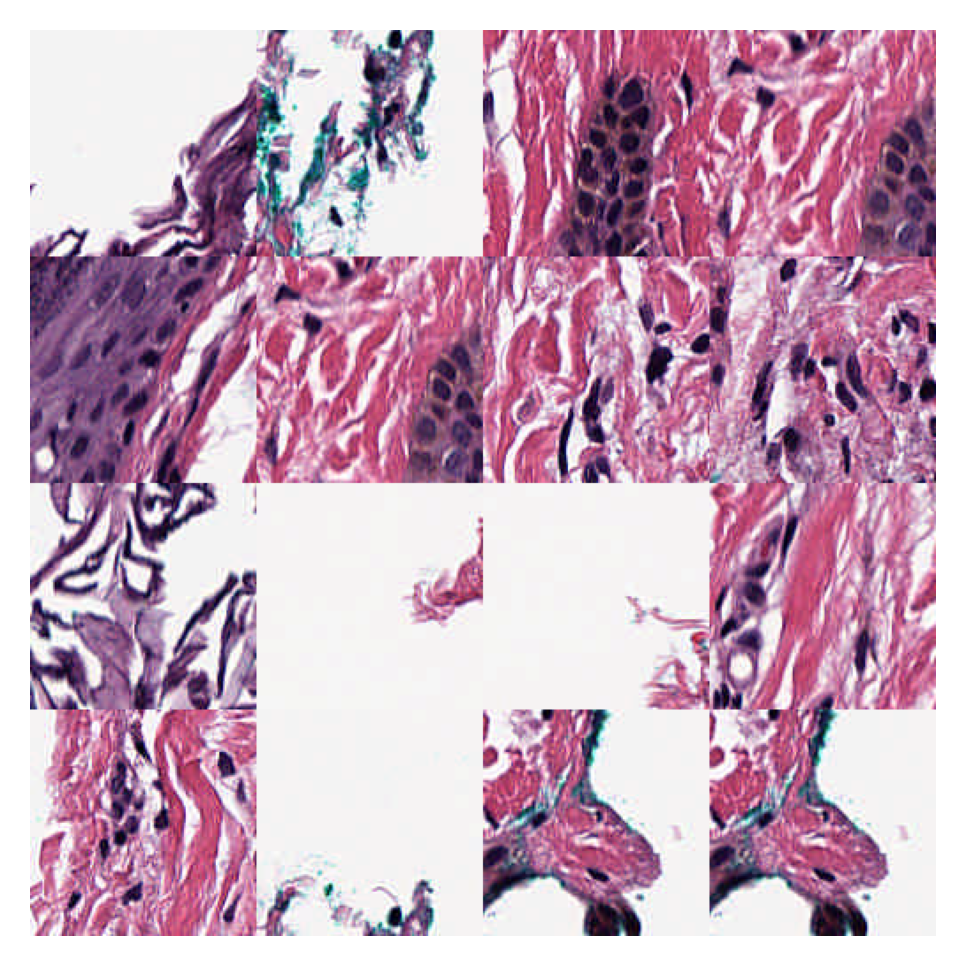

In [10]:
nr_viz_patches = 16

# for illustration purpose, only read a small amount
selected_indices = np.random.randint(0, hires_rois_top_left.shape[0], size=(4*nr_viz_patches,))
hires_rois_top_left = hires_rois_top_left[selected_indices] 

patch_list = []
for patch_coord in hires_rois_top_left:
    patch = wsi_reader.read_region(
                        patch_coord[1], patch_coord[0],
                        patch_coord[1]+hires_patch_size, 
                        patch_coord[0]+hires_patch_size,
                        level=0)
    patch_list.append(patch)

# plot the first 16
sub_patches = np.array(patch_list[:16])
sub_patches = np.reshape(sub_patches, (4, 4, hires_patch_size, hires_patch_size, 3))
sub_patches = np.transpose(sub_patches, (0, 2, 1, 3, 4))
sub_patches = np.reshape(sub_patches, (4 * hires_patch_size, 4 * hires_patch_size, 3))
plt.imshow(sub_patches)
plt.axis('off')
plt.show()


Conversely, if you want to extract the entire WSI (including the background). You can use the built-in `save_tiles` functionality of `WSIReader` object.

We start by creating another `WSIReader` object with keywords `tile_objective_value`, `tile_read_size_h`, `tile_read_size_w`, and `output_dir`. They repsectively define the magnification where the patches will be read, their expected height and expected width, and where they will be saved. For terminology, tile means image patches at sizeable dimension. For this, tiles are read at x20, each of size 1000x1000 and will be saved at the `tmp` folder within the `run_dir`.

In [11]:
# create a file handler
wsi_reader_v2 = wsireader.OpenSlideWSIReader(
                input_path=sample_wsi_path,
                output_dir=data_dir + '/output/',
                tile_objective_value=20,
                tile_read_size_h=1000,
                tile_read_size_w=1000)
wsi_reader_v2.save_tiles()


Tile0:  start_w:0, end_w:1000, start_h:0, end_h:1000, width:1000, height:1000
Tile1:  start_w:1000, end_w:2000, start_h:0, end_h:1000, width:1000, height:1000
Tile2:  start_w:2000, end_w:2220, start_h:0, end_h:1000, width:220, height:1000
Tile3:  start_w:0, end_w:1000, start_h:1000, end_h:2000, width:1000, height:1000
Tile4:  start_w:1000, end_w:2000, start_h:1000, end_h:2000, width:1000, height:1000
Tile5:  start_w:2000, end_w:2220, start_h:1000, end_h:2000, width:220, height:1000
Tile6:  start_w:0, end_w:1000, start_h:2000, end_h:2967, width:1000, height:967
Tile7:  start_w:1000, end_w:2000, start_h:2000, end_h:2967, width:1000, height:967
Tile8:  start_w:2000, end_w:2220, start_h:2000, end_h:2967, width:220, height:967


Now, we will check the content of the output folder and plot some tiles for visualization. The extracted tiles would be saved under the folder at `{data_dir}/output/{sample_file_name}`. The folder would contain a `Output.csv` which summarizes the extracted tiles.

In [12]:

import cv2
import pandas as pd

tile_summary = pd.read_csv('{data_dir}/output/{sample_file_name}/Output.csv'.format(
                            data_dir=data_dir, sample_file_name=sample_file_name))
print(tile_summary)


   iter              Tile_Name  start_w  end_w  start_h  end_h  size_w  size_h
0     0        Tile_20_0_0.jpg        0   1000        0   1000    1000    1000
1     1     Tile_20_1000_0.jpg     1000   2000        0   1000    1000    1000
2     2     Tile_20_2000_0.jpg     2000   2220        0   1000    1000     220
3     3     Tile_20_0_1000.jpg        0   1000     1000   2000    1000    1000
4     4  Tile_20_1000_1000.jpg     1000   2000     1000   2000    1000    1000
5     5  Tile_20_2000_1000.jpg     2000   2220     1000   2000    1000     220
6     6     Tile_20_0_2000.jpg        0   1000     2000   2967     967    1000
7     7  Tile_20_1000_2000.jpg     1000   2000     2000   2967     967    1000
8     8  Tile_20_2000_2000.jpg     2000   2220     2000   2967     967     220


 We will plot `Tile_20_1000_1000.jpg` as sample output.

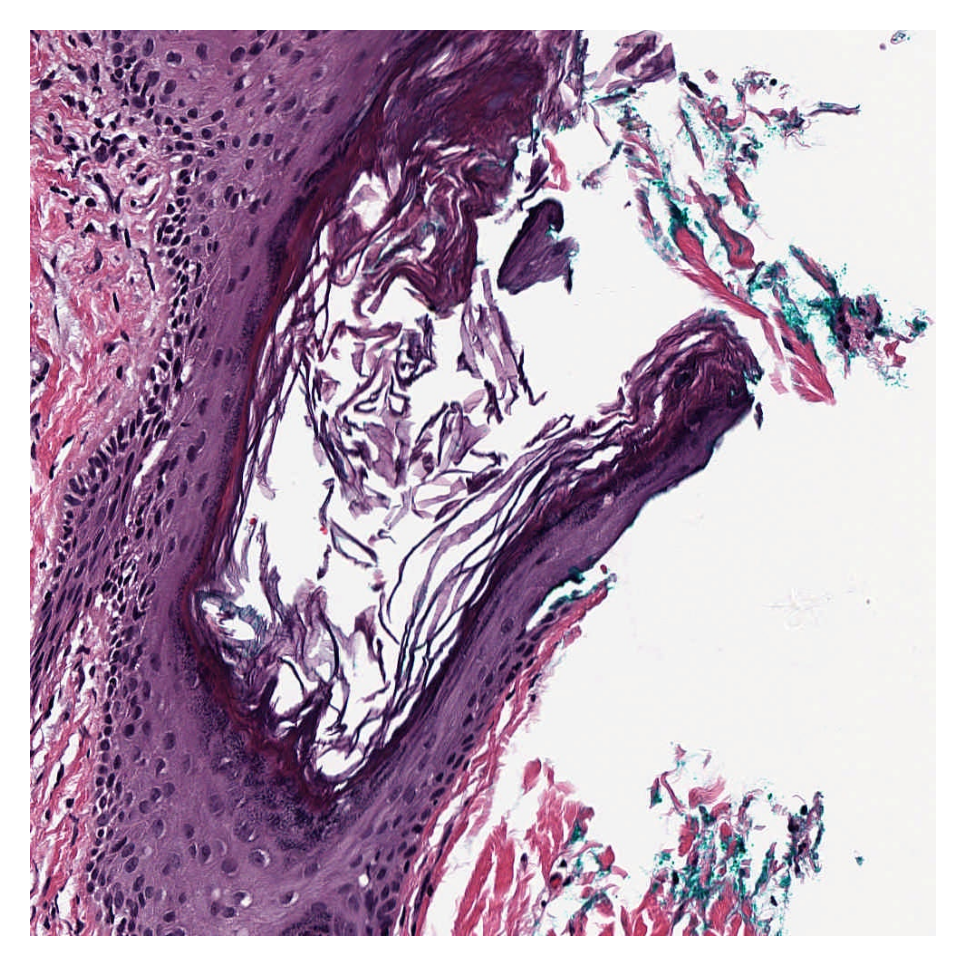

In [14]:
sample_tile = cv2.imread('%s/output/%s/%s' % (data_dir, sample_file_name, tile_summary.iloc[4]['Tile_Name']))
sample_tile = cv2.cvtColor(sample_tile, cv2.COLOR_BGR2RGB)

plt.imshow(sample_tile)
plt.axis('off')
plt.show()
